In [34]:
import os

import tensorflow.compat.v1 as tf
from nn_regressors import CNN, RNN, benchmark_model
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso, ElasticNet, Ridge
from sklearn.svm import SVR, NuSVR
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import numpy as np

from tensorflow.compat.v1.keras.models import Sequential
from tensorflow.compat.v1.keras.layers import Dense, Dropout, Activation, Embedding, LSTM, Bidirectional, Conv1D, MaxPooling1D

from lstm import create_lstm
from seq2seq import create_seq2seq

In [11]:
def clear_saved_regressors():
    to_delete = [
        "cnn_cpu.joblib",
        "cnn_mem.joblib",
        "rnn_cpu.joblib",
        "rnn_mem.joblib",
    ]
    for file in to_delete:
        if os.path.exists(file):
            os.remove(file)

In [12]:
clear_saved_regressors()

In [13]:
rnn_cpu_reg = RNN.CPURegressor()
rnn_mem_reg = RNN.MemoryRegressor()

In [14]:
# Instantiate example models.
lstm = create_lstm()
enc, dec = create_seq2seq()


models = [lstm, enc, dec]
for model in models:
    rnn_cpu_reg.add_model_data(model)
    rnn_mem_reg.add_model_data(model)


In [15]:
# Compare different regressor types

# Defines custom loss function for LGBM that penalizes underestimates.
# See https://towardsdatascience.com/custom-loss-functions-for-gradient-boosting-f79c1b40466d
def custom_asymmetric_train(y_true, y_pred):
    residual = (y_true - y_pred).astype("float")
    grad = np.where(residual > 0, -2 * 10.0 * residual, -2 * residual)
    hess = np.where(residual > 0, 2 * 10.0, 2.0)
    return grad, hess


gbm = lgb.LGBMRegressor()
gbm.set_params(
    **{"objective": custom_asymmetric_train, "num_leaves": 70, "max_bin": 400}, metrics=["mse", "mae"]
)


def get_regressors():
    return [
        Ridge(),
        RandomForestRegressor(n_estimators=750, random_state=42, criterion="mae"),
        Lasso(),
        ElasticNet(),
        SVR(),
        NuSVR(),
        gbm,
    ]

In [44]:
import matplotlib.pyplot as plt
def bar_plot(data_df, title, xlabel, ylabel, ax=None):
    if not ax:
        plt.bar(range(len(data_df)), data_df['MASE'], tick_label=data_df['Model'])
        plt.title(title)
        plt.ylabel(ylabel)
        plt.xlabel(xlabel)
        plt.xticks(rotation=90)
        plt.show()
    else:
        ax.bar(range(len(data_df)), data_df['MASE'], tick_label=data_df['Model'])
        ax.set_title(title)
        ax.set_ylabel(ylabel)
        ax.set_xlabel(xlabel)
        for tick in ax.get_xticklabels():
            tick.set_rotation(90)

# MASE evaluations

In [18]:
# Fit regressors to new model data.
rnn_cpu_reg.fit(model=SVR())  # Fit an SvR model
rnn_mem_reg.fit()  # default to Random Forest

(   units  filters  kernel_size  activation_tanh  activation_nan  \
 3   10.0     -1.0           -1                1               0   
 4   32.0     -1.0           -1                1               0   
 1  256.0     -1.0           -1                1               0   
 
    activation_selu  activation_elu  activation_softmax  activation_softplus  \
 3             -1.0            -1.0                -1.0                 -1.0   
 4             -1.0            -1.0                -1.0                 -1.0   
 1             -1.0            -1.0                -1.0                 -1.0   
 
    activation_softsign  activation_relu  activation_sigmoid  \
 3                 -1.0             -1.0                -1.0   
 4                 -1.0             -1.0                -1.0   
 1                 -1.0             -1.0                -1.0   
 
    activation_hard_sigmoid  activation_exponential  activation_linear  \
 3                     -1.0                    -1.0               -1.0  

## Predicting CPU for models the regressor was trained on

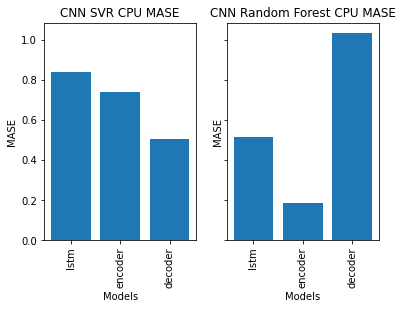

In [46]:
# Predicting CPU for models the regressor was trained on

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

rnn_cpu_reg.fit(model=SVR())  # Fit an SVR model
bar_plot(rnn_cpu_reg.evaluate_mase_multiple(models), "CNN SVR CPU MASE", "Models", "MASE", ax=ax1)

rnn_cpu_reg.fit(model=RandomForestRegressor(n_estimators=1000, random_state=42))  # Fit an SVR model
bar_plot(rnn_cpu_reg.evaluate_mase_multiple(models), "CNN Random Forest CPU MASE", "Models", "MASE", ax=ax2)

plt.show()

## Predicting CPU for models the regressor was NOT trained on

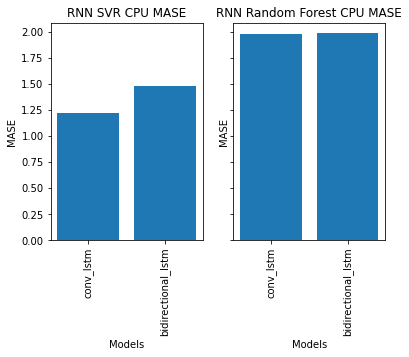

In [47]:
# Predicting CPU for models the regressor was NOT trained on
tf.keras.backend.clear_session() # IMPORTANT for layer names to match up.
test_rnn = Sequential(name="conv_lstm")
test_rnn.add(Embedding(20000, 128, input_length=100))
test_rnn.add(Dropout(0.25))
test_rnn.add(Conv1D(64,
                 5,
                 padding='valid',
                 activation='relu',
                 strides=1))
test_rnn.add(MaxPooling1D(pool_size=4))
test_rnn.add(LSTM(70))
test_rnn.add(Dense(1))
test_rnn.add(Activation('sigmoid'))
test_rnn.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


mase_1 = rnn_cpu_reg.evaluate_mase(test_rnn)


tf.keras.backend.clear_session() # IMPORTANT for layer names to match up.
test_rnn_2 = Sequential(name="bidirectional_lstm")
test_rnn_2.add(Embedding(20000, 128, input_length=100))
test_rnn_2.add(Bidirectional(LSTM(64)))
test_rnn_2.add(Dropout(0.5))
test_rnn_2.add(Dense(1, activation='sigmoid'))
test_rnn_2.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

mase_2 = rnn_cpu_reg.evaluate_mase(test_rnn_2)

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

new_models = [test_rnn, test_rnn_2]
rnn_cpu_reg.fit(model=SVR())  # Fit an SVR model
bar_plot(rnn_cpu_reg.evaluate_mase_multiple(new_models), "RNN SVR CPU MASE", "Models", "MASE", ax=ax1)

rnn_cpu_reg.fit(model=RandomForestRegressor(n_estimators=1000, random_state=42))  # Fit an SVR model
bar_plot(rnn_cpu_reg.evaluate_mase_multiple(new_models), "RNN Random Forest CPU MASE", "Models", "MASE", ax=ax2)
plt.show()

## Predicting memory for models the regressor was trained on

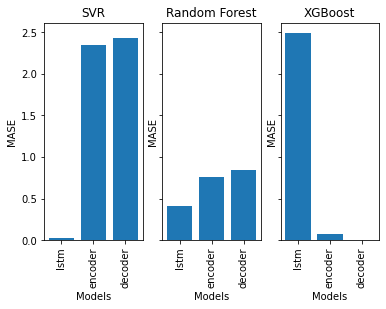

In [55]:
# Predicting memory for models the regressor was trained on
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)

rnn_mem_reg.fit(model=SVR())  # Fit an SVR model
bar_plot(rnn_mem_reg.evaluate_mase_multiple(models), "SVR", "Models", "MASE", ax=ax1)

rnn_mem_reg.fit(model=RandomForestRegressor(n_estimators=1000, random_state=42))  # Fit an SVR model
bar_plot(rnn_mem_reg.evaluate_mase_multiple(models), "Random Forest", "Models", "MASE", ax=ax2)

rnn_mem_reg.fit(model=gbm)  # Fit an SVR model
bar_plot(rnn_mem_reg.evaluate_mase_multiple(models), "XGBoost", "Models", "MASE", ax=ax3)

plt.show()

## Predicting memory for models the regressor was NOT trained on

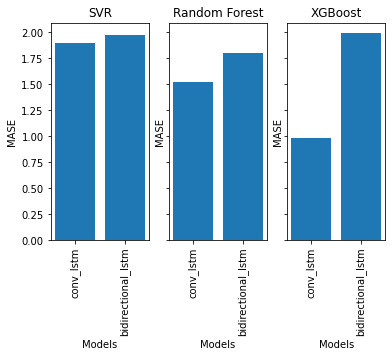

In [53]:
# Predicting memory for models the regressor was NOT trained on
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)

rnn_mem_reg.fit(model=SVR())  # Fit an SVR model
bar_plot(rnn_mem_reg.evaluate_mase_multiple(new_models), "SVR", "Models", "MASE", ax=ax1)

rnn_mem_reg.fit(model=RandomForestRegressor(n_estimators=1000, random_state=42))  # Fit an SVR model
bar_plot(rnn_mem_reg.evaluate_mase_multiple(new_models), "Random Forest", "Models", "MASE", ax=ax2)

rnn_mem_reg.fit(model=gbm)  # Fit an SVR model
bar_plot(rnn_mem_reg.evaluate_mase_multiple(new_models), "XGBoost", "Models", "MASE", ax=ax3)

plt.show()